In [429]:
import os
import torch
import numpy as np
import torch.nn as nn
from random import randint
from torch.optim import Adam
import pandas as pd
from torch.nn import BCELoss
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [399]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Contracting path (Encoder)
        # Standard size 128 -> 64 custom size 101 -> 50

        self.conv11 = nn.Conv2d(1, 16, kernel_size=3, padding='same')
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d(2, stride=2)

        # Standard size 64 -> 32 custom size 50 -> 25

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(2, stride=2)

        # Standard size 32 -> 16 custom size 25 -> 12

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(2, stride=2)

        # Standard size 16 -> 8 custom size 12 -> 6

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(2, stride=2)

        # Middle layer

        self.convM1 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.convM2 = nn.Conv2d(256, 256, kernel_size=3, padding='same')

        # Expanding path (Decoder)
        # Standard size 8 -> 16 custom size 6 -> 12

        self.upconv5 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv51 = nn.Conv2d(256, 128, kernel_size=3, padding='same')
        self.conv52 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        # Standard size 16 -> 32 custom size 12 -> 25

        self.upconv6 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv61 = nn.Conv2d(128, 64, kernel_size=3, padding='same')
        self.conv62 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        # Standard size 32 -> 64 custom size 25 -> 50

        self.upconv7 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv71 = nn.Conv2d(64, 32, kernel_size=3, padding='same')
        self.conv72 = nn.Conv2d(32, 32, kernel_size=3, padding='same')

        # Standard size 64 -> 128 custom size 50 -> 101

        self.upconv8 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv81 = nn.Conv2d(32, 16, kernel_size=3, padding='same')
        self.conv82 = nn.Conv2d(16, 16, kernel_size=3, padding='same')

        self.output = nn.Conv2d(16, 1, kernel_size=1, padding='same')
        
    def forward(self, x):
        # Contracting path (Encoder)
        c11 = F.relu(self.conv11(x))
        c12 = F.relu(self.conv12(c11))
        p1 = self.pool1(c12)

        c21 = F.relu(self.conv21(p1))
        c22 = F.relu(self.conv22(c21))
        p2 = self.pool2(c22)

        c31 = F.relu(self.conv31(p2))
        c32 = F.relu(self.conv32(c31))
        p3 = self.pool3(c32)

        c41 = F.relu(self.conv41(p3))
        c42 = F.relu(self.conv42(c41))
        p4 = self.pool4(c42)

        # Middle layer
        cM1 = F.relu(self.convM1(p4))
        cM2 = F.relu(self.convM2(cM1))

        # Expanding path (Decoder)
        up5 = self.upconv5(cM2)
        concat5 = torch.cat([up5, c42], 1)
        c51 = F.relu(self.conv51(concat5))
        c52 = F.relu(self.conv52(c51))

        up6 = self.upconv6(c52)
        concat6 = torch.cat([up6, c32], 1)
        c61 = F.relu(self.conv61(concat6))
        c62 = F.relu(self.conv62(c61))

        up7 = self.upconv7(c62)
        concat7 = torch.cat([up7, c22], 1)
        c71 = F.relu(self.conv71(concat7))
        c72 = F.relu(self.conv72(c71))

        up8 = self.upconv8(c72)
        concat8 = torch.cat([up8, c12], 1)
        c81 = F.relu(self.conv81(concat8))
        c82 = F.relu(self.conv82(c81))

        output = torch.sigmoid(self.output(c82))
        return output

In [400]:
class CustomDataset(Dataset):
    def __init__(self, ids, image_folder, mask_folder, transform=None):
        self.ids = ids
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, f"{self.ids[idx]}.png")
        mask_path = os.path.join(self.mask_folder, f"{self.ids[idx]}.png")

        image = Image.open(img_path).convert("L") 
        mask = Image.open(mask_path).convert("L")

        #Resize to fit 128x128
        target_size=(128, 128)
        image = image.resize(target_size, Image.BILINEAR)
        mask = mask.resize(target_size, Image.NEAREST)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [401]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [402]:
train_img_dir = './train/images/'
train_mask_dir = './train/masks/'
train_ids = pd.read_csv("./train/train.csv", usecols=[0]).id.values.tolist()

In [403]:
dataset = CustomDataset(train_ids, train_img_dir, train_mask_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [404]:
lr = 0.001
num_epochs = 30

In [405]:
model = UNet()
optimizer = Adam(model.parameters(), lr=lr)
criterion = BCELoss()

In [406]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


# Training

In [407]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

early_stopping_counter = 0
early_stopping_patience = 10
best_validation_loss = np.inf

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in train_loader: # We will use the same dataset as the training for ease of use
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            validation_loss += val_loss.item()

    # Calculate average validation loss
    validation_loss /= len(train_loader)

    # Update learning rate based on validation loss
    lr_scheduler.step(validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {validation_loss}")

    # Check for improvement in validation loss
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        early_stopping_counter = 0
        # Save the model weights
        torch.save(model.state_dict(), "model/bestModel.pth")
    else:
        early_stopping_counter += 1

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping: Validation loss has not improved for {} consecutive epochs.".format(early_stopping_patience))
        break


# Save the trained model
torch.save(model.state_dict(), "model/bestModel.pth")

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Training Loss: 0.4697377383708954, Validation Loss: 0.5601604955196381
Epoch 2/20, Training Loss: 0.4372270703315735, Validation Loss: 0.5466133534908295
Epoch 3/20, Training Loss: 0.5846647024154663, Validation Loss: 0.5362098984718323
Epoch 4/20, Training Loss: 0.3709520995616913, Validation Loss: 1.3747722113132477
Epoch 5/20, Training Loss: 0.6054136157035828, Validation Loss: 0.5636618790626526
Epoch 6/20, Training Loss: 0.4160468578338623, Validation Loss: 0.5522487688064576
Epoch 7/20, Training Loss: 0.5078461170196533, Validation Loss: 0.5341441645622254
Epoch 8/20, Training Loss: 0.6110735535621643, Validation Loss: 0.5120438380241394
Epoch 9/20, Training Loss: 0.460832804441452, Validation Loss: 0.49637686347961424
Epoch 10/20, Training Loss: 0.42020443081855774, Validation Loss: 0.47280767583847044
Epoch 11/20, Training Loss: 0.5238234400749207, Validation Loss: 0.4891073977947235
Epoch 12/20, Training Loss: 0.4869197607040405, Validation Loss: 0.4412845656871795

To continue further training

In [535]:
model.load_state_dict(torch.load("model/bestModel.pth"))

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

early_stopping_counter = 0
early_stopping_patience = 10
best_validation_loss = np.inf

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in train_loader: # We will use the same dataset as the training for ease of use
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            validation_loss += val_loss.item()

    # Calculate average validation loss
    validation_loss /= len(train_loader)

    # Update learning rate based on validation loss
    lr_scheduler.step(validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {validation_loss}")

    # Check for improvement in validation loss
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        early_stopping_counter = 0
        # Save the model weights
        torch.save(model.state_dict(), "model/bestModel.pth")
    else:
        early_stopping_counter += 1

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping: Validation loss has not improved for {} consecutive epochs.".format(early_stopping_patience))
        break


# Save the trained model
torch.save(model.state_dict(), "model/bestModel.pth")

Epoch 1/20, Training Loss: 0.22758586704730988, Validation Loss: 0.2506310216188431
Epoch 2/20, Training Loss: 0.1940423548221588, Validation Loss: 0.23880202227830888
Epoch 3/20, Training Loss: 0.24841967225074768, Validation Loss: 0.23452661687135695
Epoch 4/20, Training Loss: 0.27450236678123474, Validation Loss: 0.24657468032836913


KeyboardInterrupt: 

# Eval

In [481]:
model.load_state_dict(torch.load("model/bestModel.pth"))
model.eval()

UNet(
  (conv11): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv32): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv41): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv42): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convM1): Conv2d(128, 256, kernel_size

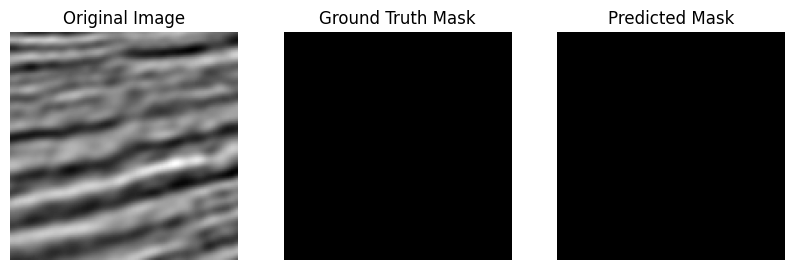

In [534]:
# Choose picture at random 
image_number = randint(0, len(train_ids))
image = train_ids[image_number]

image_path = "train/images/"+image+".png"
image = Image.open(image_path).convert("L")  # Convert to grayscale if needed
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(image.resize((128, 128), Image.BILINEAR)).unsqueeze(0)  # Add batch dimension

# Forward pass to get predictions
with torch.no_grad():
    predictions = model(input_image)

# Convert predictions to a binary mask (assuming a threshold of 0.5)
binary_predictions = (predictions > 0.5).float()

# Convert tensors to numpy arrays for visualization
input_image_np = input_image.squeeze().numpy()
binary_predictions_np = binary_predictions.squeeze().numpy()

# Plot the original image, ground truth mask, and predicted mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(input_image_np, cmap="gray")
plt.axis("off")

# Ground truth visualization
image = train_ids[image_number]
ground_truth_mask_path = "train/masks/"+image+".png"
ground_truth_mask = Image.open(ground_truth_mask_path).convert("L")
ground_truth_mask_np = transform(ground_truth_mask.resize((128, 128), Image.BILINEAR)).numpy()
plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_mask_np[0], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(binary_predictions_np, cmap="gray")
plt.axis("off")

plt.show()